# Local self-attention (practice)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.nn.modules.linear import Linear
import torch.nn as nn
from torchsummary import summary
import math

### unfold

In [2]:
# unfold = nn.Unfold(kernel_size=(2, 3))
B, C, H, W = 2, 4, 5, 6
K = 3

x = torch.randn(B, C, H, W)
out = x.unfold(2, K, 1)
print(out.shape)

torch.Size([2, 4, 3, 6, 3])


## LocalSelfAttention module

In [11]:
class LocalSelfAttention(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, bias=False):
        super(LocalSelfAttention, self).__init__()
        # in-class implementation
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        
        # define projection layers
        # (step 1) query projection layer (linear layer with a sliding window)
        self.query_linear = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        # (step 2) key projection layer (linear layer with a sliding window)
        self.key_linear = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        # (step 3) value projection layer (linear layer with a sliding window)
        self.value_linear = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        
        assert out_channels % 2 == 0
        
        # define learnable relative positional encodings
        # (step 4) positional encoding in height direction
        self.rel_h = nn.Parameter(
            torch.randn(out_channels // 2, 1, 1, kernel_size, 1), requires_grad=True
        )
        self.rel_w = nn.Parameter(
            torch.randn(out_channels // 2, 1, 1, 1, kernel_size), requires_grad=True
        )
#         self.rel = nn.Parameter(torch.randn(out_channels, 1, 1, 1, 1), requires_grad=True)
        # (step 5) positional encoding in width direction
        # Hint: initialize the positional encoding with normal distribution. torch.randn
        
    def forward(self, x):
        # in-class implementation
        batch, channels, height, width = x.size()
        
        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])
        q_out = self.query_linear(x) # (B, C, H, W)
        k_out = self.key_linear(padded_x) # (B, C, H + padding, W + padding)
        v_out = self.value_linear(padded_x)
        
        k_out = k_out.unfold(2, self.kernel_size, 1).unfold(3, self.kernel_size, 1)
        v_out = v_out.unfold(2, self.kernel_size, 1).unfold(3, self.kernel_size, 1)
        # k_out: (B, C, H, W, K, K)
        # k_out[:, :, :, :, 0, 0]
        k_out_h, k_out_w = k_out.split(self.out_channels // 2, dim=1)
        # k_out_h: (B, C//2, H, W, K, K)
        # self.rel_h: (C//2, 1, 1, K, 1), self.rel_w: (C//2, 1, 1, 1, K)
        k_out_h = k_out_h + self.rel_h
        k_out_w = k_out_w + self.rel_w
#         k_out = k_out + self.rel
        k_out = torch.cat([k_out_h, k_out_w], dim=1) # (B, C, H, W, K, K)
        
        k_out = k_out.contiguous().view(batch, self.out_channels, height, width, -1) # (B, C, H, W, K*K)
        v_out = v_out.contiguous().view(batch, self.out_channels, height, width, -1)
        
        q_out = q_out.view(batch, self.out_channels, height, width, 1) # (B, C, H, W, 1)
        out = q_out * k_out # (B, C, H, W, K*K)
        out = out / math.sqrt(self.out_channels)
        out = F.softmax(out, dim=-1)
        # v_out: (B, C, H, W, K*K)
        # out: (B, C, H, W, K*K)
        out = torch.einsum('bchwk,bchwk -> bchw', out, v_out).view(batch, -1, height, width)
        # out.shape == (B, C, H, W)
        return out

In [12]:
B, C, H, W = 2, 4, 5, 6
layer = LocalSelfAttention(C, C**2, kernel_size=3, padding=1)
x = torch.randn((B, C, H, W))
out = layer(x)

## Simple Nets

### Block

In [21]:
class SimpleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(SimpleBlock, self).__init__()
        # in-class implementation: attn -> residual connection -> relu -> output
        self.stride = stride
        
        self.attn = nn.Sequential(
            LocalSelfAttention(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride > 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        # in-class implementation
        out = self.attn(x)
        
        if self.stride > 1:
            out = F.avg_pool2d(out, (self.stride, self.stride))
            
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

### Simple Nets

In [22]:
class SimpleNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleNet, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.net = nn.Sequential(
            SimpleBlock(16, 16, stride=2),
            SimpleBlock(16, 16, stride=2),
            SimpleBlock(16, 16, stride=2),
            SimpleBlock(16, 32, stride=2) # 1/16
        )
        self.classifier = nn.Linear(32, num_classes)
        
    def forward(self, x):
        # (B, 3, 224, 224)
        out = self.stem(x)
        out = self.net(out) # (B, 32, 14, 14)
        out = F.avg_pool2d(out, 14)
        out = out.view(out.size(0), -1) # (B, 32)
        out = self.classifier(out)
        
        return out

### Load Train, Test Dataset and Define Train, Test Loader

In [23]:
# Loading and normalizing CIFAR-10
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2,
                                        shuffle=False, num_workers=2)
print(len(trainset))
print(len(testset))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
50000
10000


### For Visualization

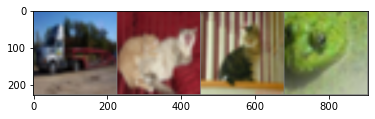

truck   cat   cat  frog


In [24]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define model

In [25]:
device = "cuda:1"
x = torch.randn(2,3,224,224).to(device)
model = SimpleNet(3, 10).to(device)
output = model(x)
print(output.shape)

torch.Size([2, 10])


### Define Loss and optimizer

In [26]:
import torch.optim as optim

# define a loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training

In [27]:
### Train the network
print('Start Training ')
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # Fill this loop
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # print statistics
        if i % 50 == 0:
            print('[%d, %5d] loss: %.6f' %
                 (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

Start Training 
[1,     1] loss: 0.004997
[1,    51] loss: 0.231984
[1,   101] loss: 0.235905
[1,   151] loss: 0.229948


KeyboardInterrupt: 

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(2)))

In [ ]:
images = images.to(device)
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(2))) 